In [2]:
import os
import pickle
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC

Define method for grid search with different classification methods

In [3]:
def perform_logistic_regression(X, y):
    # Grid search with logistic regression
    lr = LogisticRegression(C=1.0)

    # GridSearch for liblinear solver
    C_range = [0.1, 1, 10, 100, 1000, 10000]
    penalty_options = ['l1', 'l2']
    fit_intercept_options = [True, False]
    solver_option = ['liblinear']
    class_weight_option = ['auto', '']

    param_grid = dict(C=C_range, penalty=penalty_options, fit_intercept=fit_intercept_options, solver=solver_option)

    # solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
    # multi_class_options = ['ovr', 'multinomial']
    # class_weight_options = [None, 'balanced']

    # param_grid = dict(solver = solver_options, multi_class = multi_class_options, class_weight = class_weight_options)

    perform_grid_search(lr, X, y, param_grid, "Logistic Regression")
    
    for iteration in range(0, 10):
        tune_parameters_for_scores(lr, X, y, param_grid, ['accuracy'], iteration)


def perform_lda(X, y):
    lda = LinearDiscriminantAnalysis()

    solver_options = ['lsqr']
    #shrinkage_options = [None, 'auto']
    shrinkage = np.arange(0.0, 1.05, 0.05)
    
    param_grid = dict(solver=solver_options, shrinkage=shrinkage)

    perform_grid_search(lda, X, y, param_grid, "LDA")
    
    for iteration in range(0, 10):
        tune_parameters_for_scores(lda, X, y, param_grid, ['accuracy'], iteration)
    

def perform_svc(X, y):
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    
    for iteration in range(0, 10):
        tune_parameters_for_scores(SVC(), X, y, tuned_parameters, ['accuracy'], iteration)

    
def perform_grid_search(clf, X, y, param_grid, name):
    
    cv = StratifiedKFold(n_splits=10)
    
    grid_clf = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
    grid_clf.fit(X, y)

    print("# Tuning parameters for %s" % name)
    print()
    # best results
    print("The best parameters are %s with a score of %0.2f" \
          % (grid_clf.best_params_, grid_clf.best_score_))
    print()
    # complete results
    means = grid_clf.cv_results_['mean_test_score']
    stds = grid_clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("\n")


In [4]:
def tune_parameters_for_scores(method, X, y, param_grid, scores, random_state, print_grid_scores=False, test_size=False) :
    # Split the dataset in two equal parts
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=random_state)

    # Set the parameters by cross-validation
    
    cv = StratifiedKFold(n_splits=10)
    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(method, param_grid, cv=cv,
                           scoring='%s' % score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        
        if print_grid_scores:
            print("Grid scores on development set:")
            print()
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std, params))
            print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

In [5]:
CHANNELS = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FCz', 'FC6', 'T7', 'C3', 'Cz', 'C4',
            'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

Set important directories.

In [6]:
working_directory = 'L:/int_err'
current_path = os.path.abspath(working_directory)
image_directory = os.path.abspath(os.path.join(current_path, 'images'))
pickle_directory = os.path.abspath(os.path.join(current_path, 'pickles'))

Load separability indices.

In [9]:
consc_std_err_file = os.path.abspath(os.path.join(pickle_directory, 'consc_std_err.pkl'))
with open(consc_std_err_file, 'rb') as pickle_file:
    consc_std_err = pickle.load(pickle_file)
    
consc_std_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_std_corr.pkl'))
with open(consc_std_corr_file, 'rb') as pickle_file:
    consc_std_corr = pickle.load(pickle_file)
    
consc_group_rv_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_group_rv_corr.pkl'))
with open(consc_group_rv_corr_file, 'rb') as pickle_file:
    consc_group_rv_corr = pickle.load(pickle_file)
    
consc_rv_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_rv_corr.pkl'))
with open(consc_rv_corr_file, 'rb') as pickle_file:
    consc_rv_corr = pickle.load(pickle_file)  

consc_rr_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_rr_corr.pkl'))
with open(consc_rr_corr_file, 'rb') as pickle_file:
    consc_rr_corr = pickle.load(pickle_file)  

Extract features.

In [10]:
consc_std_err.extract_features([[26,50]], CHANNELS, 'Consc_Group')

consc_std_corr.extract_features([[124, 188], [192, 212], [246, 278]], CHANNELS, 'Consc_Group')
# [160, 180], [204, 240] - [120, 192], [200, 220]
consc_group_rv_corr.extract_features([[120, 192], [200, 220]], CHANNELS, 'Consc_Group')
# [160, 180], [204, 240] - [112, 168], [172, 212]
consc_rr_corr.extract_features([[112, 168], [172, 212]], CHANNELS, 'Consc_Group')

X_std, y_std = consc_std_corr.get_features_and_labels('Consc_Group')
X_rv, y_rv = consc_group_rv_corr.get_features_and_labels('Consc_Group')
X_rr, y_rr = consc_rr_corr.get_features_and_labels('Consc_Group')

In [15]:
# perform_lda(X_rr, y_rr)

In [14]:
# perform_logistic_regression(X_rr, y_rr)

In [20]:
def run_evaluation(clf, X, y, n_splits, score, ax):
    
    results = []
    
    # Variables for ROC analysis
    grand_mean_tpr = 0.0
    grand_mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    for iteration in range(0, 10):
        
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=iteration)

        # Variable for accuracy score
        mean_score = 0
        
        # Variables for ROC analysis
        mean_tpr = 0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        
        j = 0
        for train, test in cv.split(X, y):
            
            # Compute accuracy score
            y_pred = clf.fit(X[train], y[train]).predict(X[test])
            
            # Compute probas for ROC computation
            probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
            
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            
            grand_mean_tpr += interp(mean_fpr, fpr, tpr)
            grand_mean_fpr[0] = 0.0
            
            if score is 'accuracy':
                mean_score += accuracy_score(y[test], y_pred)
            elif score is 'precision':
                mean_score += precision_score(y[test], y_pred, pos_label=0)
            elif score is 'recall':
                mean_score += recall_score(y[test], y_pred, pos_label=0)
                
            j += 1

        mean_tpr /= j
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        i += 1
        
        ax.plot(mean_fpr, mean_tpr,
                label='Iteration %d / AUC = %0.2f' % (i, mean_auc), lw=0.5)
        
        # Mean accuracy
        mean_score /= j
        
        results.append(mean_score)
        
    grand_mean_tpr /= j * i
    grand_mean_fpr[-1] = 1.0
    grand_mean_auc = auc(grand_mean_fpr, grand_mean_tpr)
    
    ax.plot(grand_mean_fpr, grand_mean_tpr,
                 label='Mean' + ' / AUC = %0.2f' % grand_mean_auc, lw=3)
    
    return results

In [29]:
def run_set_of_evaluations(score, n_splits):
    # prepare plots
    fig, ax = plt.subplots(3, 2, figsize=(12, 16))
    
    ### Evaluation of classification with STD

    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.2)
    lr = LogisticRegression(C=100, fit_intercept=True, penalty='l1', solver='liblinear')

    results_lda = run_evaluation(lda, X_std, y_std, n_splits, score, ax=ax[0, 0])
    results_lr = run_evaluation(lr, X_std, y_std, n_splits, score, ax[0, 1])

    results_std = []
    results_std.append(results_lda)
    results_std.append(results_lr)

    ### Evaluation of classification with RV

    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1.0)
    lr = LogisticRegression(C=10, fit_intercept=True, penalty='l1', solver='liblinear')

    results_lda = run_evaluation(lda, X_rv, y_rv, n_splits, score, ax[1, 0])
    results_lr = run_evaluation(lr, X_rv, y_rv, n_splits, score, ax[1, 1])

    results_rv = []
    results_rv.append(results_lda)
    results_rv.append(results_lr)

    ### Evaluation of classification with RR

    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.9)
    lr = LogisticRegression(C=0.1, fit_intercept=True, penalty='l1', solver='liblinear')

    results_lda = run_evaluation(lda, X_rr, y_rr, n_splits, score, ax[2, 0])
    results_lr = run_evaluation(lr, X_rr, y_rr, n_splits, score, ax[2, 1])

    results_rr = []
    results_rr.append(results_lda)
    results_rr.append(results_lr)
    
    # make plots - ROC
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right", prop={'size':8})
    
    plot_path = os.path.abspath(os.path.join(image_directory, 'interr1_roc_comparison_lr_lda.png'))
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # make plots - bars
    results_std = np.array(results_std)
    results_rv = np.array(results_rv)
    results_rr = np.array(results_rr)

    results = []
    print(np.mean(results_std, axis=1))
    print(np.mean(results_rv, axis=1))
    print(np.mean(results_rr, axis=1))

    print(np.std(results_std, axis=1))
    print(np.std(results_rv, axis=1))
    print(np.std(results_rr, axis=1))

    results.append(results_std)
    results.append(results_rv)
    results.append(results_rr)

    results = np.array(results)

    means = np.mean(results, axis=2)
    stds = np.std(results, axis=2)

    print(means.shape)

    ind = np.arange(len(means))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width/2, means[:,0], width, yerr=stds[:,0], color='SkyBlue', label='LDA', capsize=5)
    rects2 = ax.bar(ind + width/2, means[:,1], width, yerr=stds[:,1], color='IndianRed', label='LR', capsize=5)

    ax.set_ylabel(score)
    ax.set_title('%s by instruction condition and classifier' % score)
    ax.set_xticks(ind)
    ax.set_xticklabels(('STD', 'RV', 'RR'))
    ax.legend()

    plot_path = os.path.abspath(os.path.join(image_directory, 'interr1_comparison_lr_lda.png'))

    plt.savefig(plot_path, dpi=300, bbox_inches='tight')

In [30]:
#run_set_of_evaluations('precision')

In [31]:
#run_set_of_evaluations('recall')

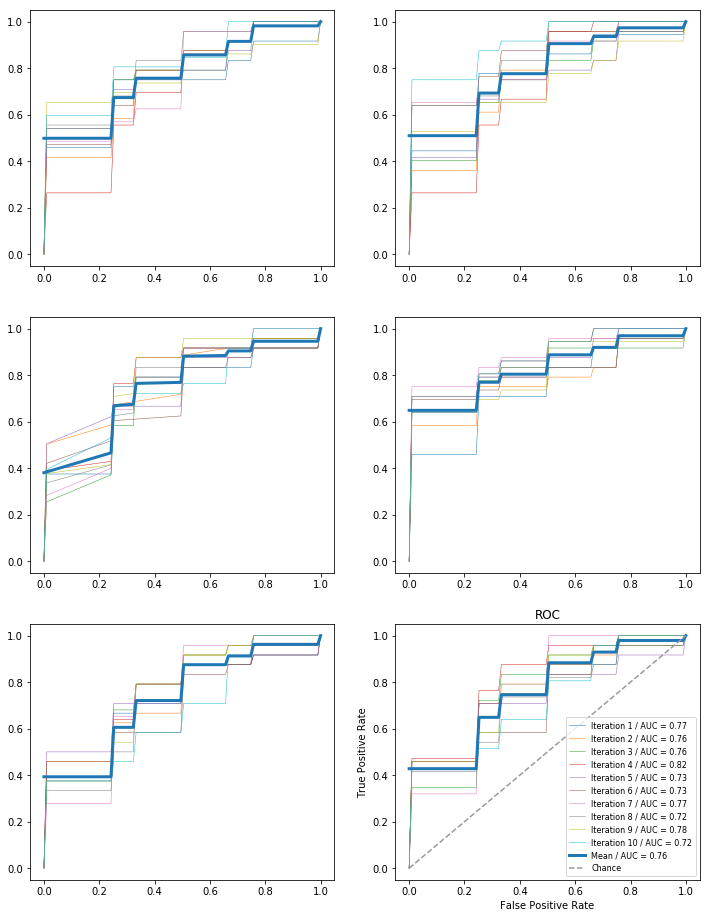

[0.6719246  0.71269841]
[0.71507937 0.72440476]
[0.67787698 0.69503968]
[0.05175501 0.08107314]
[0.01499822 0.03563097]
[0.01956177 0.01961277]
(3, 2)


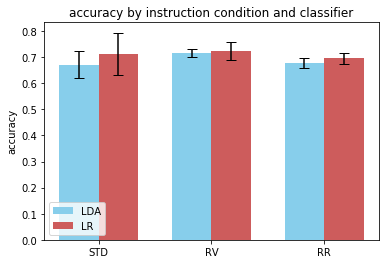

In [35]:
run_set_of_evaluations('accuracy', 6)